# Imports and Defines

## Imports
    Imports all modules and submodules that were necessary for this study.
    Special mention to TimeSeriesCrossValidation which was created with the purpose to be used in this thesis (https://github.com/DidierRLopes/TimeSeriesCrossValidation)

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as dr
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from TimeSeriesCrossValidation import splitTrain
from matplotlib.lines import Line2D
from collections import OrderedDict
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss, bds
from scipy.stats import skewtest, kurtosistest, skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

## Define Functions
    Defines helper functions

In [3]:
# Parse string into tuple
def parse_tuple(string):
    try:
        s = ast.literal_eval(str(string))
        if type(s) == tuple:
            return s
        return
    except:
        return

In [4]:
# Compute MAE over an array of different horizons
def horizon_mae(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true.T);
    list_MAE = list()
    for i in horizonSteps:
        list_MAE.append(round(np.mean(ae[0,:i]), 2))
    return list_MAE;

In [5]:
# Define Mean Absolute Percentage Error
def absolute_percentage_error(y_true, y_pred):
    if (len(y_true[y_true == 0])):
        print("Division by zero!")
        return None;
    else:
        return 100*(abs((y_pred - y_true.T) / y_true.T));

In [6]:
# Compute MAPE over an array of different horizons
def horizon_mape(y_true, y_pred, horizonSteps):
    ape = absolute_percentage_error(y_true.T, y_pred);
    if ape is not None:
        list_MAPE = list()
        for i in horizonSteps:
            list_MAPE.append(round(np.mean(ape[0,:i]), 2))
        return list_MAPE;

In [7]:
# Evaluate combinations of p, d and q values for an ARIMA model
def ARIMA_grid(dataset, arimaCfg, isLog):
    df_IC = pd.DataFrame( columns=['ARIMA(p, d, q)', 'AIC', 'BIC', 'HQIC'])
    df_IC = df_IC.set_index('ARIMA(p, d, q)')
    dict_arimaFit  = {} 
    dict_arimaPred = {} 
    modelNum = 0;
    totalModelNum = len(arimaCfg.p_range)*len(arimaCfg.d_range)*len(arimaCfg.q_range)
    for p in arimaCfg.p_range:
        for d in arimaCfg.d_range:
            for q in arimaCfg.q_range:
                order = (p,d,q)
                modelNum+=1;
                print("%d/%d " % (modelNum, totalModelNum))

                try:
                    model = ARIMA(dataset, order=order);
                    model_fit = model.fit(disp=0);
                    
                    if (~np.isnan(model_fit.mle_retvals.get('fopt'))):
                        
                        model_str = 'ARIMA' + str(order)
                        df_IC = df_IC.append(pd.DataFrame({'AIC':model_fit.aic, 'BIC':model_fit.bic, \
                                                           'HQIC':model_fit.hqic}, index =[model_str]), ignore_index=False)

                        if (isLog):
                            dict_arimaFit[model_str]  = np.e**(model_fit.predict(typ='levels'));
                            dict_arimaPred[model_str] = np.e**(model_fit.forecast(steps=stepsToForecast[-1])[0]);
                        else:
                            dict_arimaFit[model_str]  = model_fit.predict(typ='levels');
                            dict_arimaPred[model_str] = model_fit.forecast(steps=stepsToForecast[-1])[0];
                except:
                    continue
    return dict_arimaFit, dict_arimaPred, df_IC

## Define Univariate Time-Series
    df: Dataframe with an index and a value column
    title: Title of data being used
    xlab: Label of df.index
    ylab: Label of df.values
    
    stepsToForecast: Steps to forecast out-of-sample (and in-sample)

In [8]:
previousStepsToShow = 15;

#stepsToForecast = [1, 3, 12]
#df = dr.DataReader('CPIAUCSL', "fred", start='1947-01-01', end='2019-09-01')
#df_train = df[['CPIAUCSL']][:-stepsToForecast[-1]].rename(columns={'CPIAUCSL': 'train'})
#df_test = df[['CPIAUCSL']][-stepsToForecast[-1]:].rename(columns={'CPIAUCSL': 'test'})
#title = 'CPIAUC'
#xlab = 'Months/Year'; 
#ylab = 'CPI: Index 1982-1984=100 (Seasonally Adjusted)';

#stepsToForecast = [1, 5, 21]
#df = pd.read_csv("PSI_20_Data_1992_Stooq.csv") 
#df = pd.DataFrame(df, columns= ['Date','Close'])
#df.set_index('Date', drop=True, inplace=True)
#df.index = pd.to_datetime(df.index)
#df = df.truncate(before='2002-01-01', after='2019-09-27')
#df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
#df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
#title = 'PSI20: Historical Closing Prices'
#xlab = 'Working Days/Year'; 
#ylab = 'Closing Price (Euro)';

stepsToForecast = [1, 5, 21]
df = dr.data.get_data_yahoo('SPY', start= '1993-01-01', end='2019-09-27')
df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
title = 'SP500'
xlab = 'Days/Year'; 
ylab = 'Closing Price ($)';

# Stationarity of the Time-Series

## Data transformation and its graphical representation
    This section allows to understand the representation of the series after its transformation to achieve stationarity

    Box-Cox transformations such as the logarithmic one can help to stabilise the variance of a time series. 
    Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.
    Note: The order Box-Cox transformation, and then, differencing, is important!

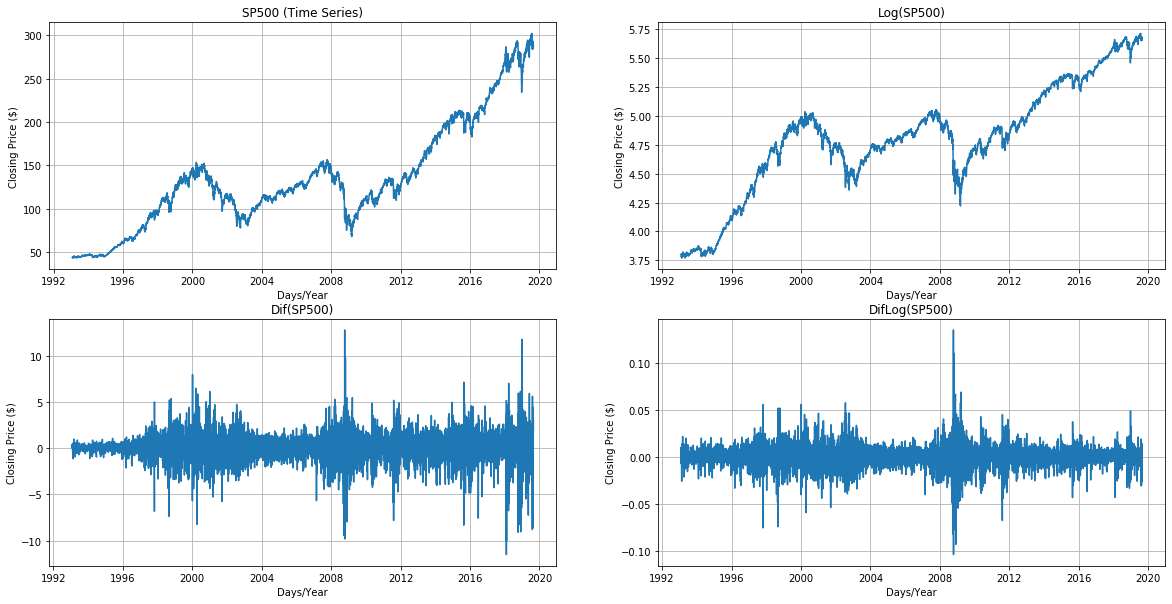

In [9]:
fig = plt.figure(figsize=(20,10))

fig.add_subplot(221)
plt.title(title + ' (Time Series)')
plt.plot(df_train)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(222)
plt.title('Log(' + title + ')')
plt.plot(np.log(df_train))
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(223)
plt.title('Dif(' + title + ')')
plt.plot(df_train.diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(224)
plt.title('DifLog(' + title + ')')
plt.plot(np.log(df_train).diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

plt.show()

## Normality tests

### Jarque-Bera test
    Perform the Jarque-Bera goodness of fit test on sample data.
    The Jarque-Bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution.

In [10]:
jb, jbpval = stats.jarque_bera(df_train)
print("Jarque-Bera Test for " + title)
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(np.log(df_train))
print("Jarque-Bera Test for Log(" + title + ")")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(df_train.diff().dropna())
print("Jarque-Bera Test for Diff(" + title + ")")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(np.log(df_train).diff().dropna())
print("Jarque-Bera Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval) 

Jarque-Bera Test for SP500
Statistic: 726.0377
p-value: 0.0000

Jarque-Bera Test for Log(SP500)
Statistic: 135.9271
p-value: 0.0000

Jarque-Bera Test for Diff(SP500)
Statistic: 12828.4972
p-value: 0.0000

Jarque-Bera Test for Diff(Log(SP500))
Statistic: 29088.8787
p-value: 0.0000


### Kolmogorov-Smirnov test
    Perform the Kolmogorov-Smirnov test for goodness of fit.
    This performs a test of the distribution G(x) of an observed random variable against a given distribution F(x). Under the null hypothesis the two distributions are identical, G(x)=F(x). The alternative hypothesis can be either 'two-sided' (default), 'less' or 'greater'. The KS test is only valid for continuous distributions.

In [11]:
ks, kspval = stats.kstest(df_train.values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)  
print("")
ks, kspval = stats.kstest(np.log(df_train), 'norm')
print("Kolmogorov-Smirnov Test for Log(" + title + ")")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)
print("")
ks, kspval = stats.kstest(df_train.diff().dropna(), 'norm')
print("Kolmogorov-Smirnov Test for Diff(" + title + ")")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)
print("")
ks, kspval = stats.kstest(np.log(df_train).diff().dropna(), 'norm')
print("Kolmogorov-Smirnov Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

Kolmogorov-Smirnov Test
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Log(SP500)
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Diff(SP500)
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Diff(Log(SP500))
Statistic: 0.5539
p-value: 0.0000


## Unit Root and Stationarity Tests

### The Augmented Dickey-Fuller test 
    Augmented Dickey-Fuller unit root test.
    The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

In [12]:
result = adfuller(df_train['train'].values, regression='c')
print("Augmented Dickey Fuller Test for " + title)
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")
result = adfuller(np.log(df_train['train'].values), regression='c')
print("Augmented Dickey Fuller Test for Log(" + title + ")")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")
result = adfuller(df_train['train'].diff().dropna(), regression='c')
print("Augmented Dickey Fuller Test for Diff(" + title + ")")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print ("\t%s: %.3f" % (key, value))
print("")
result = adfuller(np.log(df_train['train']).diff().dropna().values, regression='c')
print("Augmented Dickey Fuller Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))

Augmented Dickey Fuller Test for SP500
Statistic: 0.3972
p-value: 0.9814
Used lags: 17
Num obs: 6676
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Augmented Dickey Fuller Test for Log(SP500)
Statistic: -1.1596
p-value: 0.6907
Used lags: 34
Num obs: 6659
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Augmented Dickey Fuller Test for Diff(SP500)
Statistic: -20.1409
p-value: 0.0000
Used lags: 16
Num obs: 6676
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Augmented Dickey Fuller Test for Diff(Log(SP500))
Statistic: -14.7617
p-value: 0.0000
Used lags: 33
Num obs: 6659
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Kwiatkowski-Phillips-Schmidt-Shin test
    Kwiatkowski-Phillips-Schmidt-Shin test for stationarity.
    Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.

In [13]:
result = kpss(df_train['train'].values, regression='c')
print("KPSS Test for " + title)
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(np.log(df_train['train'].values), regression='c')
print("KPSS Test for Log(" + title + ")")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(df_train['train'].diff().dropna(), regression='c')
print("KPSS Test for Diff(" + title + ")")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(np.log(df_train['train']).diff().dropna().values, regression='c')
print("KPSS Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));

KPSS Test for SP500
Statistic: 13.2820
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

KPSS Test for Log(SP500)
Statistic: 13.2698
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

KPSS Test for Diff(SP500)
Statistic: 0.2234
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

KPSS Test for Diff(Log(SP500))
Statistic: 0.1275
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347


## Correlation plots
    These plots are useful for identifying non-stationary time series 

    This also gives an idea of the order of the model by:
        AR(p) - p from the partial autocorrelation plot
        I(d)  - d from the number of Diffs your dataset is using
        MA(q) - q from the autocorrelation plot

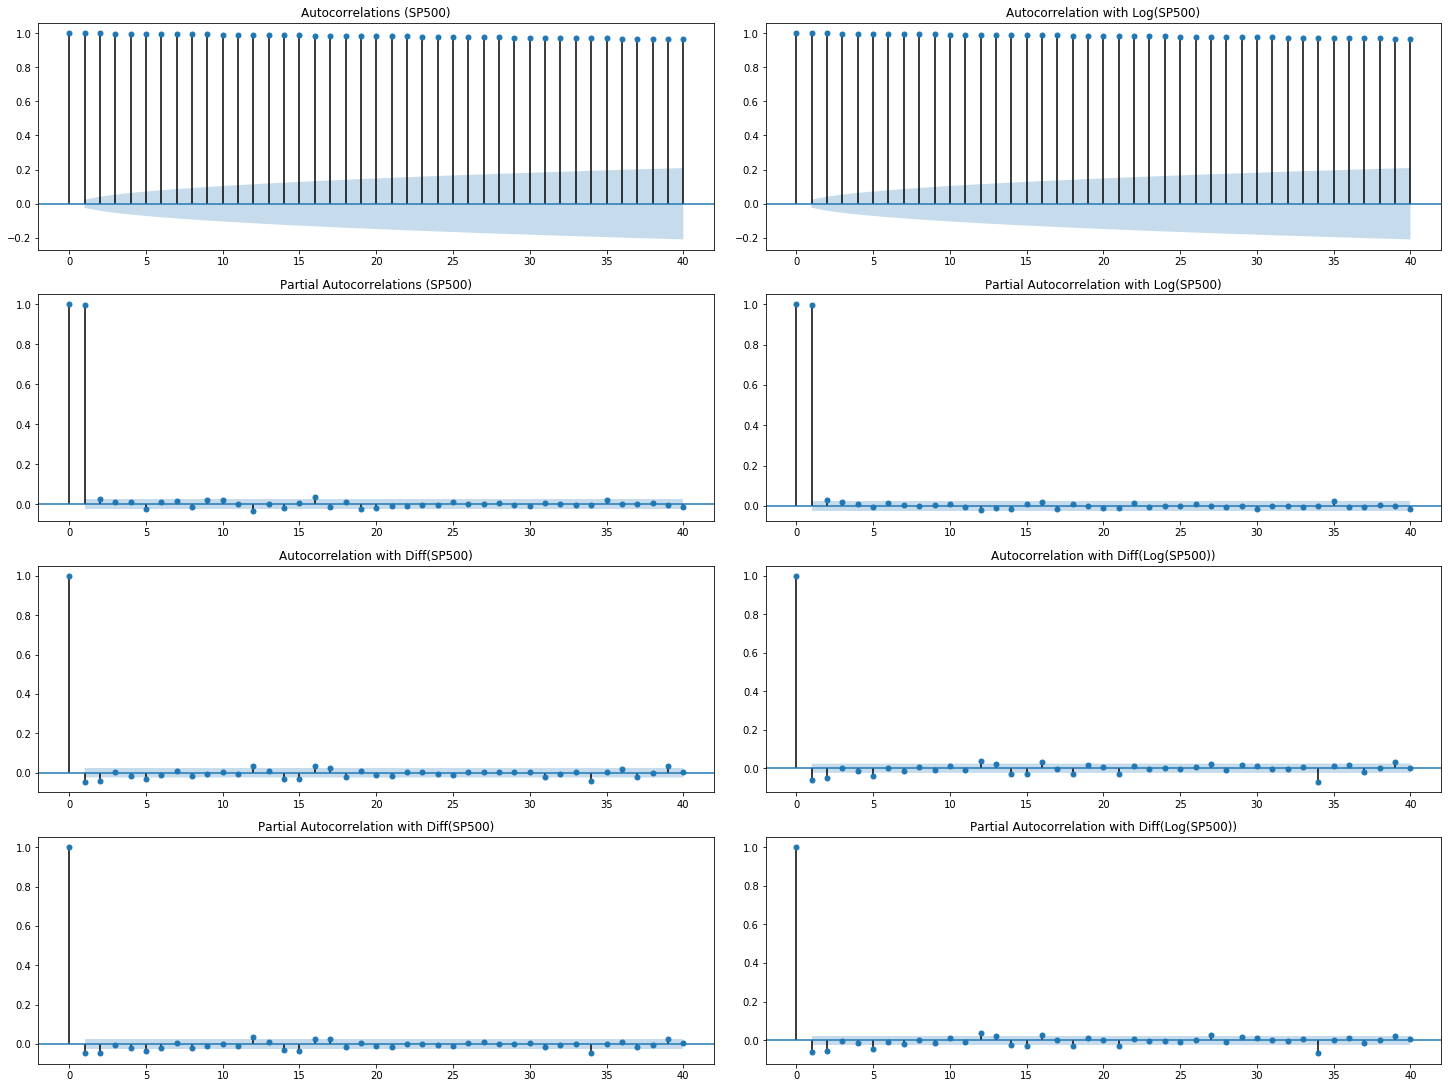

In [14]:
maxLags = 40

fig = plt.figure(figsize=(20,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

# Auto-correlation function for original time series
ax_acf = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df_train, lags=maxLags, ax=ax_acf, title='Autocorrelations (' + title + ')')
# Partial auto-correlation function for original time series
ax_pacf = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df_train, lags=maxLags, ax=ax_pacf, title='Partial Autocorrelations (' + title + ')');

# Auto-correlation function for time series transformed with Log
ax_acfLog = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(np.log(df_train), lags=maxLags, ax=ax_acfLog, title='Autocorrelation with Log('+ title + ')')
# Partial auto-correlation function for time series transformed with Log
ax_pacfLog = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train), lags=maxLags, ax=ax_pacfLog, title='Partial Autocorrelation with Log('+ title + ')');

# Auto-correlation function for time series transformed with Diff
ax_acfDiff = fig.add_subplot(spec[2, 0])
sm.graphics.tsa.plot_acf(df_train.diff().dropna(), lags=maxLags, ax=ax_acfDiff, title='Autocorrelation with Diff('+ title + ')')
# Partial auto-correlation function for time series transformed with Diff
ax_pacfDiff = fig.add_subplot(spec[3, 0])
sm.graphics.tsa.plot_pacf(df_train.diff().dropna(), lags=maxLags, ax=ax_pacfDiff, title='Partial Autocorrelation with Diff('+ title + ')');

# Auto-correlation function for time series transformed with Log
ax_acfDiffLog = fig.add_subplot(spec[2, 1])
sm.graphics.tsa.plot_acf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_acfDiffLog, title='Autocorrelation with Diff(Log('+ title + '))')
# Partial auto-correlation function for time series transformed with Log
ax_pacfDiffLog = fig.add_subplot(spec[3, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_pacfDiffLog, title='Partial Autocorrelation with Diff(Log('+ title + '))');

plt.show()

# ARIMA Selection

## Pre-processing
    From now on, we must choose whether we go with the Log(Time-Series) or not. This should be done to remove stationarity of the data, so that ARIMA can work. In addition, if the model is multiplicative we need to use log to make it additive as ARIMA relies on that assumption. The previously seen differentiated data enters in the I component of the ARIMA model it will take care of differenciating for us.

In [15]:
isLog = True

if (isLog):
    df_Train = pd.DataFrame(np.log(df_train), index = df_train.index).copy()
else:
    df_Train = df_train.copy()

## Model training
    In this section we will train several ARIMA models based on distinct (p,d,q) combinations.
    Not only train but also forecast, and extract their AIC, BIC and HQIC.

In [16]:
# Range of ARIMA models to compute
class arimaCfg:
    p_range = range(4, 5) # [1,7)
    d_range = range(1, 3) # [1,3)
    q_range = range(3, 6) # [1,7)

dict_arimaFit, dict_arimaPred, df_IC = ARIMA_grid(df_Train.values, arimaCfg, isLog)
#dict_arimaFit, dict_arimaPred, df_IC

1/6 
2/6 
3/6 
4/6 
5/6 
6/6 


## Model Comparison based on Information Criteria
    AIC - Akaike information criterion (AIC) is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data.
    BIC - Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models. It is based, in part, on the likelihood function and it is closely related to AIC.
    HQIC - Hannan–Quinn information criterion (HQIC) is a criterion for model selection. It is an alternative to AIC and BIC.

In [17]:
print(df_IC[['AIC']].sort_values('AIC').head().rename(columns={'AIC': 'TOP 5 AIC'}))
print(" ")
print(df_IC[['BIC']].sort_values('BIC').head().rename(columns={'BIC': 'TOP 5 BIC'}))
print(" ")
print(df_IC[['HQIC']].sort_values('HQIC').head().rename(columns={'HQIC': 'TOP 5 HQIC'}))

                   TOP 5 AIC
ARIMA(4, 1, 3) -40850.258442
ARIMA(4, 1, 4) -40848.954401
ARIMA(4, 2, 4) -40782.127143
ARIMA(4, 2, 3) -40780.961164
ARIMA(4, 2, 5) -40776.678978
 
                   TOP 5 BIC
ARIMA(4, 1, 3) -40788.979085
ARIMA(4, 1, 4) -40780.866226
ARIMA(4, 2, 3) -40719.683152
ARIMA(4, 2, 4) -40714.040463
ARIMA(4, 2, 5) -40701.783630
 
                  TOP 5 HQIC
ARIMA(4, 1, 3) -40829.094884
ARIMA(4, 1, 4) -40825.439336
ARIMA(4, 2, 3) -40759.797912
ARIMA(4, 2, 4) -40758.612418
ARIMA(4, 2, 5) -40750.812781


## Selected Models Information Criteria Comparison
    Evaluate models based on their Information Criteria (IC)

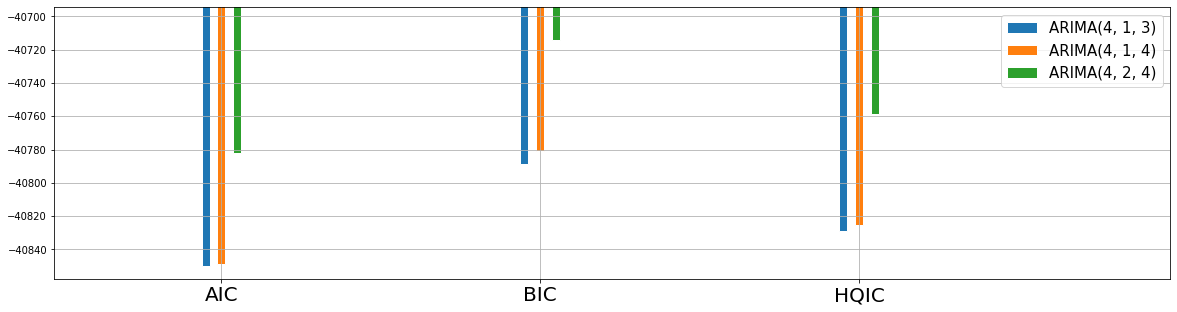

In [19]:
labels = ['ARIMA(4, 1, 3)',
          'ARIMA(4, 1, 4)',
          'ARIMA(4, 2, 4)']


plt.figure(figsize=(20,5))
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
spacing = 0.05
barWidth = 0.025
r = np.arange(3) - ((len(labels)/2)-1)*spacing

for i in np.arange(len(labels)):
    plt.bar(r, df_IC.loc[labels[i]].values, width=barWidth, edgecolor='white', label=labels[i])
    r = [x + spacing for x in r]
 
plt.xticks([r + barWidth for r in range(3)], ['AIC', 'BIC', 'HQIC'], fontsize='20')
plt.axis((-0.5, 3.0, min(df_IC.min())-0.05*(max(df_IC.max())-min(df_IC.min())), max(df_IC.max())+0.05*(max(df_IC.max())-min(df_IC.min()))))
plt.legend(loc='best')
plt.grid()
plt.show()

## Selected Models Cross-Validation
    Although IC provides an estimate of the quality of each model, relative to each of the other models. It does so by analyzing the models itself, and not having a look into the data. Another raised question is, which IC should be followed in this case.
    By applying cross-validation and having a look at the data itself, and the model, simultaneously. It will be possible to estimate the prediction performance, but also, which model is the most likely to perform better with un-seen data.

In [20]:
labels = ['ARIMA(4, 2, 3)',
          'ARIMA(4, 1, 3)']

# Select data to be used for cross-validation
Xcv, ycv = splitTrain.split_train_variableInput(sequence = df_Train.values[-540:], 
                                                minSamplesTrain = 200, 
                                                numOutputs = stepsToForecast[-1], 
                                                numJumps = 10)

dict_MAE = {} 
for model_str in labels:
    list_conv = list()
    list_mae = list()
    list_mape = list()
    print("%s" % model_str);
    for i in np.arange(len(Xcv)):
        try:
            model = ARIMA(Xcv[i], order=parse_tuple(model_str[5:]));
            model_fit = model.fit(disp=0);

            if (~np.isnan(model_fit.mle_retvals.get('fopt'))):
                if (isLog):
                    predictions_array = np.e**(model_fit.forecast(steps=stepsToForecast[-1])[0]);
                else:
                    predictions_array = model_fit.forecast(steps=stepsToForecast[-1])[0];

                list_conv.append(i+1)

                mae = horizon_mae(ycv[i], predictions_array, stepsToForecast)
                list_mae.append(mae)

                mape = horizon_mape(ycv[i], predictions_array, stepsToForecast)
                list_mape.append(mape)

                print("%d/%d" % (i+1, len(Xcv)));
        except:
            continue
    print("")

    dict_MAE[model_str] =  {'conv': list_conv, 'mae': list_mae, 'mape': list_mape}  

ARIMA(4, 2, 3)
14/32
15/32
16/32
17/32
18/32
19/32
20/32
21/32
22/32
23/32
24/32
25/32
26/32
27/32
28/32
29/32
30/32
31/32
32/32

ARIMA(4, 1, 3)
1/32
2/32
3/32
4/32
5/32
6/32
7/32
8/32
9/32
10/32
11/32
12/32
13/32
17/32
19/32
20/32
21/32
22/32
24/32
25/32
26/32
27/32
28/32
29/32
30/32
31/32
32/32



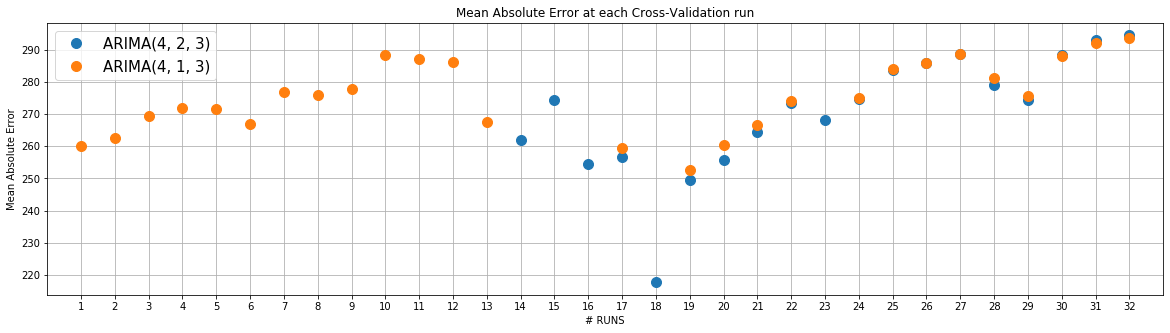

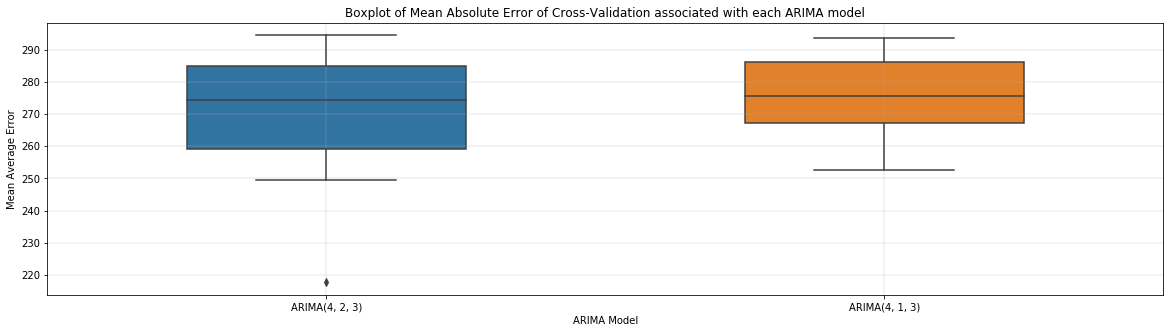

ARIMA(4, 2, 3)
Prediction for 21 Days/Year: MAE = 270.44 (4804.08%)
ARIMA(4, 1, 3)
Prediction for 21 Days/Year: MAE = 275.52 (4887.92%)


In [21]:
labels = ['ARIMA(4, 2, 3)',
          'ARIMA(4, 1, 3)']

# Select index of stepsToForecast to assess cross-validation from
PRED_IX = 3


plt.figure(figsize=(20,5));
for model_str in labels:
    plt.plot(dict_MAE[model_str]['conv'], [mae[PRED_IX-1] for mae in dict_MAE[model_str]['mae']], 'o', markersize=10)
plt.legend(labels)
plt.xlabel('# RUNS')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error at each Cross-Validation run')
if (len(Xcv) > 500):
    plt.xticks(np.arange(0, len(Xcv), 100))
if (len(Xcv) > 250):
    plt.xticks(np.arange(0, len(Xcv), 50))
elif (len(Xcv) > 50):
    plt.xticks(np.arange(0, len(Xcv), 10))
else:
    plt.xticks(np.arange(1,len(Xcv)+1))
plt.xlim([0, len(Xcv)+1])
plt.grid()
plt.show();

plt.figure(figsize=(20, 5))
y_bp = []
x_bp = np.empty((0))
for model_str in labels:
    if (len(dict_MAE[model_str]['conv'])>0):
        maeVals = [mae[PRED_IX-1] for mae in dict_MAE[model_str]['mae']]
        y_bp.extend(maeVals)
        x_bp = np.append(x_bp, np.repeat(model_str, len(maeVals)))
        df_bp = pd.DataFrame(data={'ARIMA Model': x_bp, 'Mean Average Error': y_bp})
bplot=sns.boxplot(y='Mean Average Error', x='ARIMA Model', data=df_bp, width=0.5) 
plt.title('Boxplot of Mean Absolute Error of Cross-Validation associated with each ARIMA model');
plt.grid(linewidth=.3)
plt.show();

for i in np.arange(len(labels)):
    if (len(dict_MAE[labels[i]]['conv'])>0):
        print(labels[i])
        print('Prediction for ' + str(stepsToForecast[PRED_IX-1]) + ' ' + xlab + ': MAE = ' \
              + str(round(np.mean([mae[PRED_IX-1] for mae in dict_MAE[labels[i]]['mae']]), 2)) \
              + ' (' + str(round(np.mean([mape[PRED_IX-1] for mape in dict_MAE[labels[i]]['mape']]), 2)) + '%)' )

# Model Validation
    This section allows to validate the selected model

In [22]:
# Pick you favourite's models order
order = (4, 1, 3)

model = ARIMA(df_Train.values, order=order)
model_fit = model.fit(disp=0);
df_res = pd.DataFrame({"resid": model_fit.resid}, index = df_Train.index[order[1]:])
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 6693
Model:                 ARIMA(4, 1, 3)   Log Likelihood               20434.129
Method:                       css-mle   S.D. of innovations              0.011
Date:                Sun, 15 Mar 2020   AIC                         -40850.258
Time:                        22:26:44   BIC                         -40788.979
Sample:                             1   HQIC                        -40829.095
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      2.473      0.013    5.83e-05       0.001
ar.L1.D.y     -0.0543      0.087     -0.623      0.534      -0.225       0.117
ar.L2.D.y     -0.4905      0.077     -6.360      0.000      -0.642      -0.339
ar.L3.D.y      0.6531      0.092      7.086      0.000       0.472       0.834
ar.L4.D.y     -0.0036      0.017     -0.215      0.830      -0.036       0.029
ma.L1.D.y     -0.0095      0.086     -0.110      0.912      -0.179       0.160
ma.L2.D.y      0.4373      0.068      6.459      0.000       0.305       0.570
ma.L3.D.y     -0.6993      0.083     -8.403      0.000      -0.862      -0.536
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3725           -0.9415j            1.0125           -0.3100
AR.2           -0.3725           +0.9415j            1.0125            0.3100
AR.3            1.4996           -0.0000j            1.4996           -0.0000
AR.4          182.9632           -0.0000j          182.9632           -0.0000
MA.1           -0.3741           -0.9493j            1.0204           -0.3097
MA.2           -0.3741           +0.9493j            1.0204            0.3097
MA.3            1.3735           -0.0000j            1.3735           -0.0000
-----------------------------------------------------------------------------
"""

## Model Residual Analysis
    Plots residual and its histogram

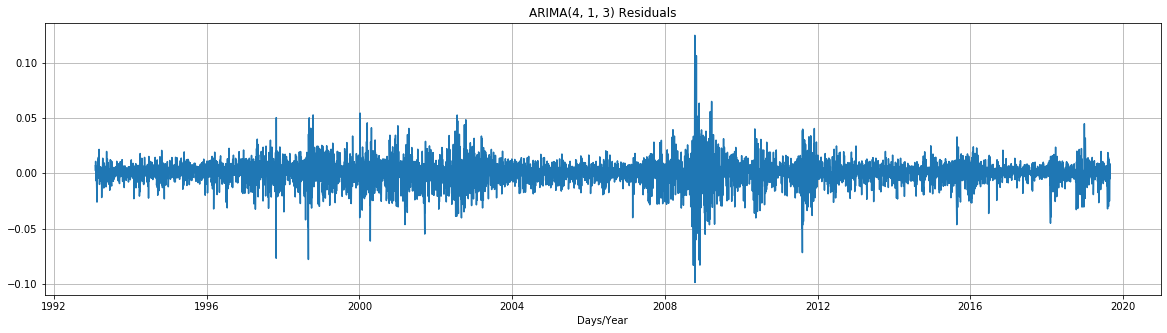

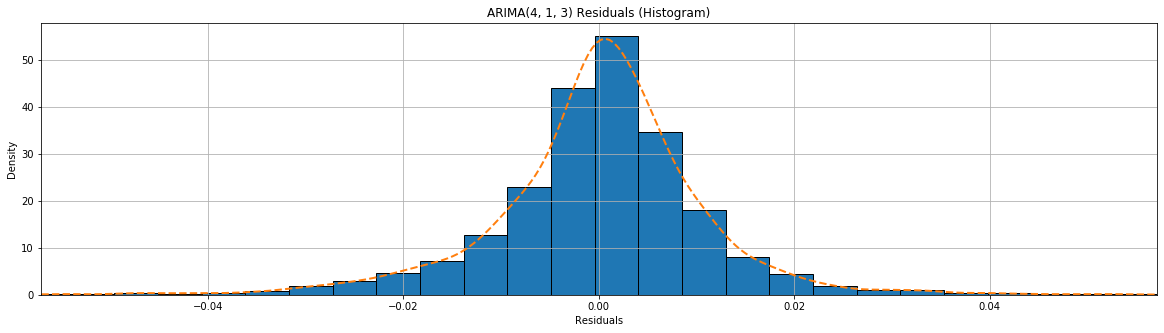

Mean: 0.000000
Variance: 0.000131


In [84]:
# Plot model residual
plt.figure(figsize=(20,5))
plt.plot(df_res.index, df_res.values)
plt.xlabel(xlab)
plt.title('ARIMA' + str(order) +' Residuals')
plt.grid()
plt.show()

# Plot histogram
plt.figure(figsize=(20,5))
plt.title('ARIMA' + str(order) + ' Residuals (Histogram)')
hist_res = df_res['resid'].hist(bins=50, normed=1, edgecolor='black')
df_res['resid'].plot(kind='kde', linewidth=2, linestyle='--')
plt.xlabel('Residuals')
limX = np.mean(df_res.values)+5*np.std(df_res.values);
plt.xlim((-limX, limX))
plt.grid()
plt.show()

print ("Mean: %.6f" % np.mean(df_res))
print ("Variance: %.6f" % np.var(df_res))

## Normality Test

### Kurtosis and Kurtosis Test
    Compute the kurtosis (Fisher or Pearson) of a dataset.
    Kurtosis is the fourth central moment divided by the square of the variance. If Fisher's definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution. If bias is False then the kurtosis is calculated using k statistics to eliminate bias coming from biased moment estimators

    Test whether a dataset has normal kurtosis.
    This function tests the null hypothesis that the kurtosis of the population from which the sample was drawn is that of the normal distribution: kurtosis = 3(n-1)/(n+1).

In [85]:
k, kpval = kurtosistest(df_res['resid'].values)
kurtosis_val = kurtosis(df_res['resid'].values, fisher=True)
print("Kurtosis Test")
print("Statistic: %.4f" % k)
print("p-value: %.4f" % kpval)
print("Kurtosis value: %.4f" % kurtosis_val)

Kurtosis Test
Statistic: 33.3858
p-value: 0.0000
Kurtosis value: 9.1466


### Skew and Skewness Test
    Compute the skewness of a data set.
    For normally distributed data, the skewness should be about 0. For unimodal continuous distributions, a skewness value > 0 means that there is more weight in the right tail of the distribution. The function `skewtest` can be used to determine if the skewness value is close enough to 0, statistically speaking.

    Test whether the skew is different from the normal distribution.
    This function tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution.

In [86]:
s, spval = skewtest(df_res['resid'].values)
skew_val = skew(df_res['resid'].values)
print("Skew Test")
print("Statistic: %.4f" % s)
print("p-value: %.4f" % spval) 
print("Skewness value: %.4f" % skew_val) 

Skew Test
Statistic: -11.4114
p-value: 0.0000
Skewness value: -0.3513


### Jarque-Bera and Kolmogorov-Smirnov tests
    Tests for goodness of fit (previously mentioned)

In [87]:
jb, jbpval= stats.jarque_bera(df_res['resid'].values)
print("Jarque-Bera Test")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)

print(" ")

ks, kspval = stats.kstest(df_res['resid'].values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

Jarque-Bera Test
Statistic: 23468.4959
p-value: 0.0000
 
Kolmogorov-Smirnov Test
Statistic: 0.4810
p-value: 0.0000


### Engle's Test for Autoregressive Conditional Heteroscedasticity (ARCH)

In [91]:
lm, lmpval, fval, fpval = het_arch(df_res['resid'].values)
print('Lagrange multiplier test statistic')
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')
print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)

Lagrange multiplier test statistic
LM Statistic: 1969.3622
LM-Test p-value: 0.0000

fstatistic for F test
F Statistic: 79.4694
F-Test p-value: 0.0000


## Test for No Autocorrelation

### Brock–Dechert–Scheinkman test
    Calculate the BDS test statistic for independence of a time series

In [93]:
result = bds(df_res['resid'].values, max_dim=6);
print("BDS Test")
print("Dim 2: z-static %.4f Prob %.4f" % (result[0][0], result[1][0]))
print("Dim 3: z-static %.4f Prob %.4f" % (result[0][1], result[1][1]))
print("Dim 4: z-static %.4f Prob %.4f" % (result[0][2], result[1][2]))
print("Dim 5: z-static %.4f Prob %.4f" % (result[0][3], result[1][3]))
print("Dim 6: z-static %.4f Prob %.4f" % (result[0][4], result[1][4]))

BDS Test
Dim 2: z-static 16.6594 Prob 0.0000
Dim 3: z-static 24.1020 Prob 0.0000
Dim 4: z-static 28.3843 Prob 0.0000
Dim 5: z-static 32.4387 Prob 0.0000
Dim 6: z-static 35.9405 Prob 0.0000


### Breusch-Godfrey test
    Breusch Godfrey Lagrange Multiplier tests for residual autocorrelation

In [92]:
lm, lmpval, fval, fpval = acorr_breusch_godfrey(model_fit, nlags = max(order[0], order[2]))
print('Lagrange multiplier test statistic')
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')
print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)

Lagrange multiplier test statistic
LM Statistic: 0.1049
LM-Test p-value: 0.9987

fstatistic for F test
F Statistic: 0.1283
F-Test p-value: 0.9722


### Box-Pierce and Ljung-Box tests
    Ljung-Box and Box-Pierce statistic differ in their scaling of the autocorrelation function. Ljung-Box test is reported to have better small sample properties.

In [160]:
maxLags = 21
lbvalue, pvalue, bpvalue, bppvalue = acorr_ljungbox(df_res['resid'].values, lags = range(1, maxLags), boxpierce=True)

index = pd.MultiIndex.from_product([range(1, maxLags)], names=['lags'])
columns = pd.MultiIndex.from_product([['Box-Pierce', 'Ljung-Box'], ['Stats', 'p-value']], names=['Test', 'Statistics'])
data = np.array([bpvalue, bppvalue, lbvalue, pvalue])

boxTests = pd.DataFrame(data.T, index=index, columns=columns)
boxTests

Test          Box-Pierce               Ljung-Box          
Statistics         Stats   p-value         Stats   p-value
lags                                                      
1           7.034913e-07  0.999331  7.038066e-07  0.999331
2           2.980839e-02  0.985206  2.982621e-02  0.985198
3           3.171082e-01  0.956779  3.173407e-01  0.956735
4           5.138648e-01  0.972137  5.142738e-01  0.972097
5           1.375953e+00  0.926926  1.377264e+00  0.926784
6           1.804391e+00  0.936781  1.806215e+00  0.936630
7           3.845176e+00  0.797427  3.849747e+00  0.796912
8           9.066352e+00  0.336730  9.078733e+00  0.335698
9           1.028502e+01  0.327908  1.029940e+01  0.326795
10          1.030958e+01  0.413766  1.032401e+01  0.412542
11          1.091163e+01  0.450696  1.092723e+01  0.449379
12          2.227054e+01  0.034597  2.230994e+01  0.034189
13          2.239713e+01  0.049506  2.243682e+01  0.048952
14          2.412573e+01  0.044245  2.416956e+01  0.043707
15          2.667735e+01  0.031478  2.672768e+01  0.031035
16          2.809255e+01  0.030824  2.814669e+01  0.030367
17          2.811334e+01  0.043631  2.816754e+01  0.043018
18          3.048756e+01  0.032968  3.054888e+01  0.032440
19          3.052025e+01  0.045540  3.058167e+01  0.044847
20          3.057843e+01  0.061008  3.064004e+01  0.060125

### QQplot
    Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution.
    Can take arguments specifying the parameters for dist or fit them automatically.

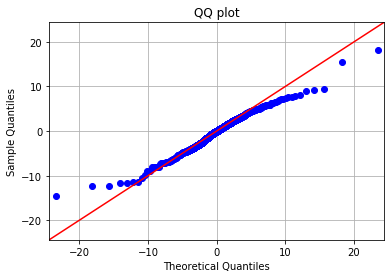

In [32]:
qqplot(df_res['resid'].values, stats.t, fit=True, line='45')
plt.title('QQ plot');
plt.grid()
plt.show()

### Plot Auto-correlation and Partial Auto-correlation functions
    Plots lags on the horizontal and the correlations on vertical axis.

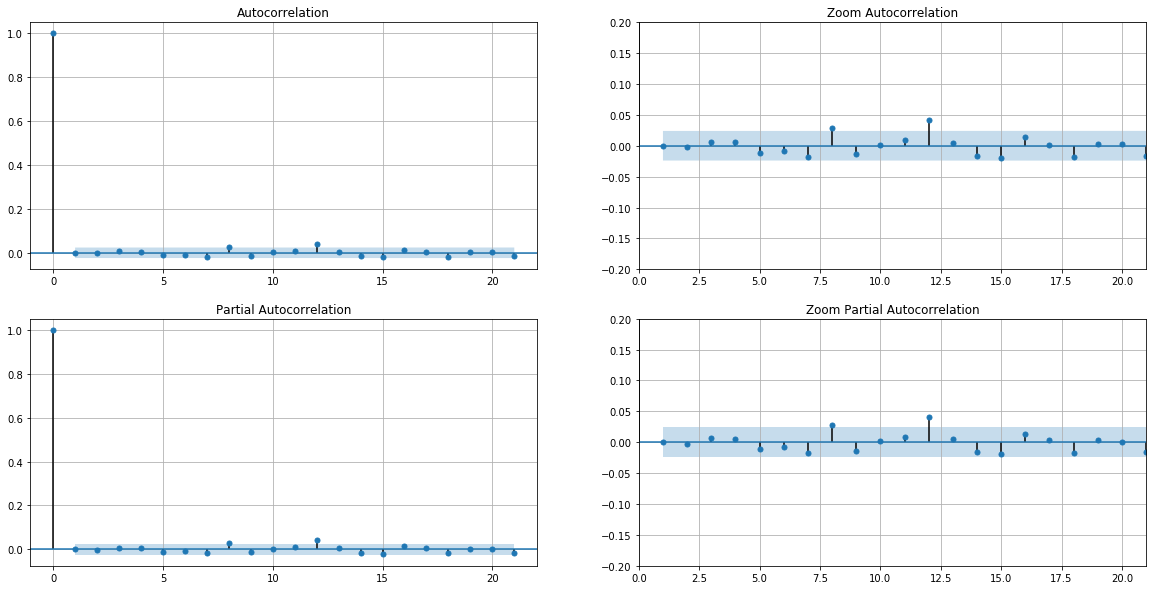

In [33]:
fig = plt.figure(figsize=(20,10))

# Auto-correlation function
ax1 = fig.add_subplot(221)
ax1.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax1)
ax2 = fig.add_subplot(222)
ax2.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax2, title = 'Zoom Autocorrelation')
ax2.axis((0, maxLags, -0.2, 0.2))

# Partial auto-correlation function
ax3 = fig.add_subplot(223)
ax3.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax3);
ax4 = fig.add_subplot(224)
ax4.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax4, title = 'Zoom Partial Autocorrelation')
ax4.axis((0, maxLags, -0.2, 0.2));

plt.show()

# Model Prediction       
    This section allows to see the forecast of the model that was selected and validated.

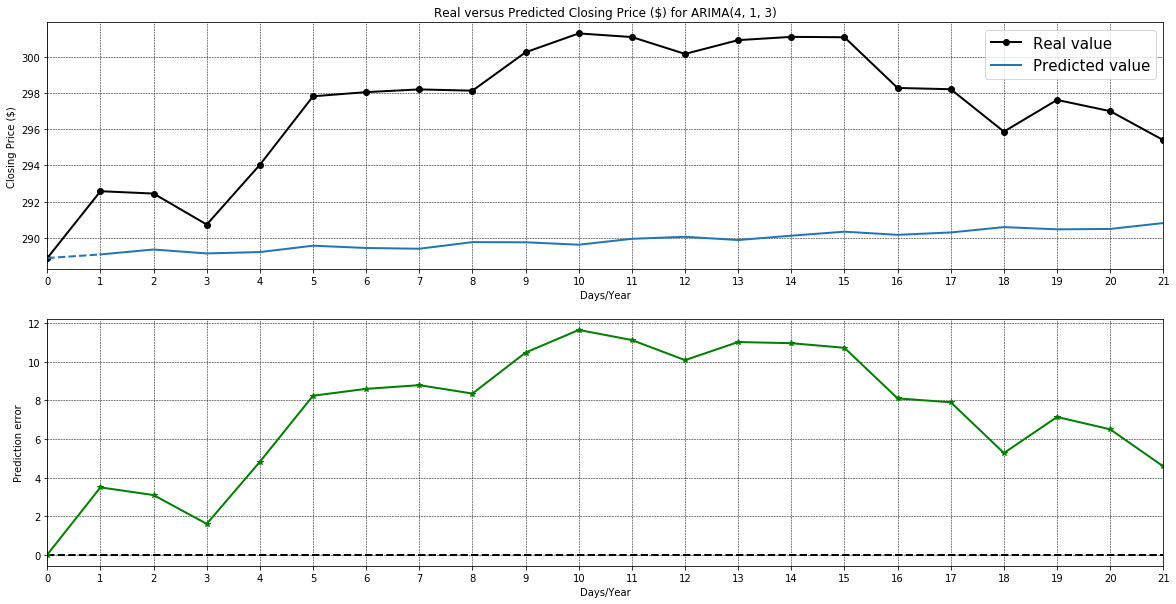

ARIMA(4, 1, 3)
Prediction for 1 Days/Year: MAE = 3.49 (1.19%)
Prediction for 5 Days/Year: MAE = 4.25 (1.13%)
Prediction for 21 Days/Year: MAE = 7.74 (0.92%)
ARIMA(4, 2, 3)
Prediction for 1 Days/Year: MAE = 3.49 (1.19%)
Prediction for 5 Days/Year: MAE = 4.25 (1.13%)
Prediction for 21 Days/Year: MAE = 7.74 (0.92%)


In [55]:
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Real versus Predicted ' + ylab + ' for ARIMA' + str(order)) 
plt.plot(range(0, stepsToForecast[-1]+1), np.concatenate((df_train.values[-1], df_test.values.flatten()), axis=0), 'k-o', linewidth=2)
plt.plot(range(1, stepsToForecast[-1]+1), dict_arimaPred['ARIMA' + str(order)], color = cmap(0), linewidth=2)
plt.plot([0,1], [df_train.values[-1][0], dict_arimaPred['ARIMA' + str(order)][0]], '--', color = cmap(0), linewidth=2)

plt.xlim([0,stepsToForecast[-1]])
plt.xticks(np.arange(0, stepsToForecast[-1]+1, step=1))
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.legend(['Real value', 'Predicted value'])

plt.subplot(212)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.plot(range(0,stepsToForecast[-1]+1), np.concatenate((np.array([0]), df_test.values.flatten()-dict_arimaPred['ARIMA' + str(order)]), axis=0), 'g-*', linewidth=2)
plt.xticks(np.arange(0, stepsToForecast[-1]+1, step=1))
plt.xlim([0, stepsToForecast[-1]])
plt.xlabel(xlab)
plt.ylabel('Prediction error')
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.show()

for i in np.arange(len(labels[1:])):
    mae  = horizon_mae(df_test.values, dict_arimaPred['ARIMA' + str(order)], stepsToForecast)
    mape = horizon_mape(df_test.values, dict_arimaPred['ARIMA' + str(order)], stepsToForecast)
    print(labels[i+1])
    for i in np.arange(len(stepsToForecast)):
        print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = ' \
              + str(round(mae[i], 2)) + ' (' + str(round(mape[i], 2)) + '%)' )

In [51]:
# Forecasted values of ARIMA model
dict_arimaPred['ARIMA' + str(order)]

array([289.09091478, 289.36170897, 289.14548888, 289.22128867,
       289.57234589, 289.44658639, 289.40435877, 289.77038965,
       289.76068144, 289.62734872, 289.95165985, 290.06482058,
       289.88533578, 290.12500905, 290.34593416, 290.17156595,
       290.30301251, 290.59807914, 290.47583218, 290.49737102,
       290.82171151])

## Model Prediction Overview
    Compare: Fitted values of the model with the training data
             Predicted values of the model with the testing data
      
    This section allows to see the forecast of the model that was selected and validated, but also to compare it against other models.

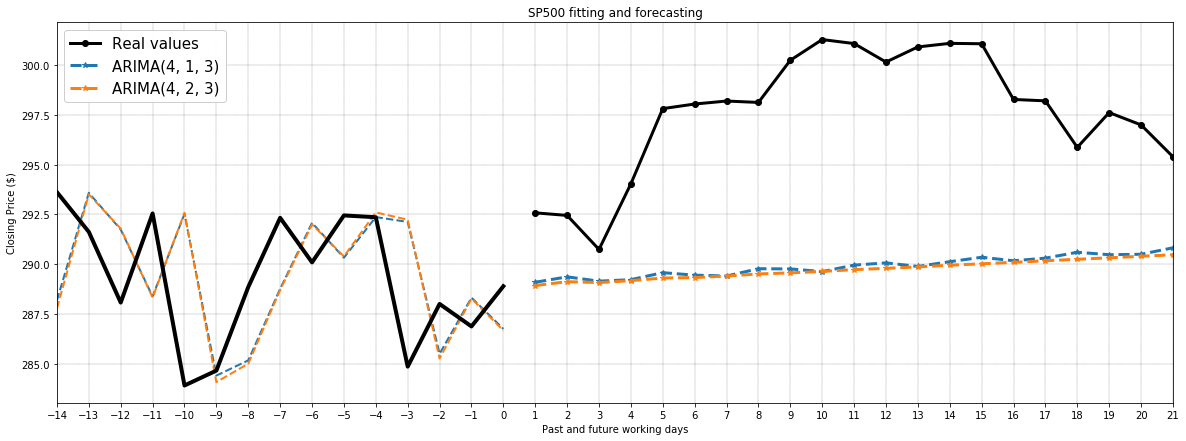

ARIMA(4, 1, 3)
Prediction for 1 Days/Year: MAE = 3.49 (1.19%)
Prediction for 5 Days/Year: MAE = 4.25 (1.13%)
Prediction for 21 Days/Year: MAE = 7.74 (0.92%)

ARIMA(4, 2, 3)
Prediction for 1 Days/Year: MAE = 3.65 (1.25%)
Prediction for 5 Days/Year: MAE = 4.41 (1.18%)
Prediction for 21 Days/Year: MAE = 7.91 (0.98%)



In [56]:
labels = ['Real Closing price', 
          'ARIMA(4, 1, 3)',
          'ARIMA(4, 2, 3)']

plt.figure(figsize=(20,7))
plt.title(title + ' fitting and forecasting')
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o', linewidth = 3, label='Real values')
for i in np.arange(len(labels)-1):
    arimaPlot = plt.plot(1+np.arange(stepsToForecast[-1]), dict_arimaPred[labels[i+1]], '--*' , linewidth = 3, label = labels[i+1] )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, dict_arimaFit[labels[i+1]][-previousStepsToShow:], '--' , linewidth = 2, color=arimaPlot[0].get_color())
plt.legend(loc='upper left', framealpha=0.95)
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 4 ) # label = labels[i+1]  legenda
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow,+stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future working days')
plt.ylabel(ylab);
plt.show()

for i in np.arange(len(labels[1:])):
    mae  = horizon_mae(df_test.values, dict_arimaPred[labels[i+1]], stepsToForecast)
    mape = horizon_mape(df_test.values, dict_arimaPred[labels[i+1]], stepsToForecast)
    print(labels[i+1])
    for i in np.arange(len(stepsToForecast)):
        print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = ' \
              + str(round(mae[i], 2)) + ' (' + str(round(mape[i], 2)) + '%)' )
    print("")